In [1]:
pip install colorama

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import json 
import numpy as np 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import pickle
import colorama 
from colorama import Fore, Style, Back
import random

In [92]:
with open('intents.json') as file:
    data = json.load(file)
    
training_sentences = []
training_labels = []
labels = []
responses = []


for intent in data['intents']:
    for pattern in intent['patterns']:
        training_sentences.append(pattern)
        training_labels.append(intent['tag'])
    responses.append(intent['responses'])
    
    if intent['tag'] not in labels:
        labels.append(intent['tag'])
        
num_classes = len(labels)

In [5]:
!pip install nlpaug

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 KB 24.6 MB/s eta 0:00:00


In [43]:
print(training_labels)

['greeting', 'greeting', 'greeting', 'greeting', 'greeting', 'greeting', 'greeting', 'greeting', 'greeting', 'greeting', 'greeting', 'greeting', 'morning', 'afternoon', 'evening', 'night', 'goodbye', 'goodbye', 'goodbye', 'goodbye', 'goodbye', 'goodbye', 'goodbye', 'goodbye', 'thanks', 'thanks', 'thanks', 'thanks', 'thanks', 'no-response', 'neutral-response', 'about', 'about', 'about', 'about', 'about', 'about', 'about', 'about', 'skill', 'creation', 'creation', 'creation', 'name', 'name', 'name', 'help', 'help', 'help', 'help', 'help', 'help', 'help', 'sad', 'sad', 'sad', 'sad', 'sad', 'sad', 'sad', 'sad', 'stressed', 'stressed', 'stressed', 'stressed', 'stressed', 'worthless', 'worthless', 'worthless', 'worthless', 'worthless', 'depressed', 'depressed', 'depressed', 'depressed', 'happy', 'happy', 'happy', 'happy', 'happy', 'happy', 'happy', 'casual', 'casual', 'casual', 'casual', 'casual', 'casual', 'casual', 'casual', 'casual', 'casual', 'casual', 'anxious', 'anxious', 'not-talking'

In [97]:
import nlpaug.augmenter.word as naw

# List of training sentences
sentences = ['I like cats', 'The dog barked', 'She ate the cake']

# Initialize augmentation object
aug = naw.SynonymAug(aug_src='wordnet')

# Augment sentences
aug_sentences = []
for sentence in training_sentences:
    aug_sentence = aug.augment(sentence)
    aug_sentences.append(aug_sentence)
    
# Print augmented sentences
#print(aug_sentences)
#print(training_labels)

#expand the training sentences and the labels to enlarge the dataset
training_sentences.extend(aug_sentences)
training_labels.extend(training_labels)

print(len(training_sentences))
print(len(training_labels))

7424
7424


In [98]:
lbl_encoder = LabelEncoder()
lbl_encoder.fit(training_labels)
training_labels = lbl_encoder.transform(training_labels)

In [99]:
vocab_size = 1000
embedding_dim = 16
max_len = 20
oov_token = "<OOV>"

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_sentences)
padded_sequences = pad_sequences(sequences, truncating='post', maxlen=max_len)

##CHATGPT MODEL

In [80]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Bidirectional, Dense, Dropout, Concatenate, Dot, Activation, Flatten, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping
from keras.regularizers import l2

In [100]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
model.add(Bidirectional(LSTM(4, recurrent_dropout=0.2,return_sequences=True)))
#model.add(Dropout(0.5))
#model.add(Bidirectional(LSTM(8, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='adam', metrics=['CategoricalAccuracy'])

model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, 20, 16)            16000     
                                                                 
 bidirectional_34 (Bidirecti  (None, 20, 8)            672       
 onal)                                                           
                                                                 
 dropout_30 (Dropout)        (None, 20, 8)             0         
                                                                 
 dense_22 (Dense)            (None, 20, 16)            144       
                                                                 
 dropout_31 (Dropout)        (None, 20, 16)            0         
                                                                 
 flatten_18 (Flatten)        (None, 320)               0         
                                                     

In [69]:
from keras.utils import to_categorical

one_hot_labels = to_categorical(training_labels, num_classes)
#print(one_hot_labels.shape)
print(training_labels)

[44 44 44 44 44 44 44 44 44 44 44 44 55  1 10 58 43 43 43 43 43 43 43 43
 73 73 73 73 73 60 57  0  0  0  0  0  0  0  0 67  5  5  5 56 56 56 48 48
 48 48 48 48 48 65 65 65 65 65 65 65 65 70 70 70 70 70 78 78 78 78 78  8
  8  8  8 45 45 45 45 45 45 45  4  4  4  4  4  4  4  4  4  4  4  2  2 61
 61 61 61 68 68 68 68 68 68 66 66 66 66  6  6  6  6  6  6 74 74 74 74 74
 74  9  9  9  9  9 72 72 72 72 72 47 47 47 46 46 46  7  7  7  7  7  7  7
  7 49 49 64 64 64 79 79 79 79 71 71 71 71 52 52 52 69 69 69 69 42  3 63
 63 59 59 59 51 51 51 76 76 53 53 77 77 62 75 75 75 50 50 50 54 54 11 11
 22 22 33 33 37 37 37 37 38 38 39 39 39 40 41 12 13 14 15 16 17 18 19 20
 21 23 24 25 26 27 28 29 29 30 31 32 34 35 36 36 44 44 44 44 44 44 44 44
 44 44 44 44 55  1 10 58 43 43 43 43 43 43 43 43 73 73 73 73 73 60 57  0
  0  0  0  0  0  0  0 67  5  5  5 56 56 56 48 48 48 48 48 48 48 65 65 65
 65 65 65 65 65 70 70 70 70 70 78 78 78 78 78  8  8  8  8 45 45 45 45 45
 45 45  4  4  4  4  4  4  4  4  4  4  4  2  2 61 61

In [101]:
epochs = 50
history = model.fit(padded_sequences, training_labels, epochs=epochs, verbose=1, validation_split=0.1)

Epoch 1/50
209/209 [==============================] - 18s 52ms/step - loss: 4.2103 - categorical_accuracy: 0.0115 - val_loss: 4.1769 - val_categorical_accuracy: 0.0000e+00
Epoch 2/50
209/209 [==============================] - 10s 48ms/step - loss: 4.0681 - categorical_accuracy: 0.0045 - val_loss: 3.9841 - val_categorical_accuracy: 0.0000e+00
Epoch 3/50
169/209 [=======================>......] - ETA: 1s - loss: 3.8331 - categorical_accuracy: 0.0063

KeyboardInterrupt: ignored

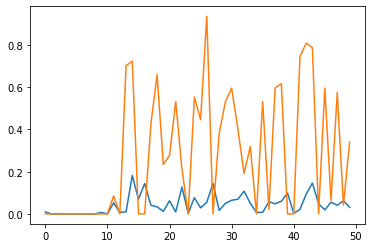

In [78]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])

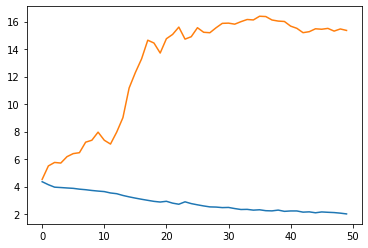

In [64]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [65]:
# to save the trained model
model.save("chat_model")

# to save the fitted tokenizer
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
# to save the fitted label encoder
with open('label_encoder.pickle', 'wb') as ecn_file:
    pickle.dump(lbl_encoder, ecn_file, protocol=pickle.HIGHEST_PROTOCOL)

In [66]:
with open("intents.json") as file:
    data = json.load(file)


def chat():
    # load trained model
    model = keras.models.load_model('chat_model')

    # load tokenizer object
    with open('tokenizer.pickle', 'rb') as handle:
        tokenizer = pickle.load(handle)

    # load label encoder object
    with open('label_encoder.pickle', 'rb') as enc:
        lbl_encoder = pickle.load(enc)

    # parameters
    max_len = 20
    
    while True:
        print(Fore.LIGHTBLUE_EX + "User: " + Style.RESET_ALL, end="")
        inp = input()
        if inp.lower() == "quit":
            break

        result = model.predict(keras.preprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences([inp]),
                                             truncating='post', maxlen=max_len))
        #print(result)                                    
        tag = lbl_encoder.inverse_transform([np.argmax(result)])
        print(tag)
        for i in data['intents']:
            if i['tag'] == tag:
                print(Fore.GREEN + "ChatBot:" + Style.RESET_ALL , np.random.choice(i['responses']))

        # print(Fore.GREEN + "ChatBot:" + Style.RESET_ALL,random.choice(responses))

print(Fore.YELLOW + "Start messaging with the bot (type quit to stop)!" + Style.RESET_ALL)
chat()

Start messaging with the bot (type quit to stop)!
User: hello
1/1 [==============================] - 2s 2s/step
['greeting']
ChatBot: Hi there. How are you feeling today?
User: whats going on
1/1 [==============================] - 0s 27ms/step
['sleep']
ChatBot: What do you think is the reason behind this?
User: i feel fucking exhausted
1/1 [==============================] - 0s 41ms/step
['done']
ChatBot: Okay I see. Enjoy the rest of your day then
User: i'm so tired
1/1 [==============================] - 0s 31ms/step
['worthless']
ChatBot: It's only natural to feel this way. Tell me more. What else is on your mind?
User: i hate my life
1/1 [==============================] - 0s 38ms/step
['location']
ChatBot: Somewhere in the universe
User: i am sad
1/1 [==============================] - 0s 29ms/step
['sad']
ChatBot: I'm here for you. Could you tell me why you're feeling this way?
User: sadness consumes me
1/1 [==============================] - 0s 30ms/step
['depressed']
ChatBot: Talk 

KeyboardInterrupt: ignored